In [1]:
%matplotlib inline

import pymc3 as pm
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from collections import defaultdict, Counter
import pickle

sb.set()

np.set_printoptions(suppress=True, precision=2, threshold=8)

### Lettura dati sul voto

Leggo i voti delle Politiche 2018, e le trasformo in una tabella `COMUNE, ELETTORI, *partiti`

In [2]:
scrutini = pd.read_csv("../data/camera_2018_scrutini_italia.csv", encoding='latin', sep=';')

voti = scrutini[['COMUNE', 'LISTA', 'VOTILISTA']].copy()
voti['VOTILISTA'] = voti['VOTILISTA'].astype(int)

elettori = scrutini[['COMUNE', 'ELETTORI']].copy().drop_duplicates().reset_index(drop=True)
elettori = elettori.groupby('COMUNE').sum().reset_index()

voti = voti.pivot_table(index='COMUNE', columns='LISTA', values='VOTILISTA',
                        aggfunc="sum", margins=True).fillna(0).astype(int)

partiti2sigla = {
 ' +EUROPA': '+E',
 'FORZA ITALIA': 'FI',
 "FRATELLI D'ITALIA CON GIORGIA MELONI": 'FdI',
 'LEGA': 'LEGA',
 'LIBERI E UGUALI': 'LeU',
 'MOVIMENTO 5 STELLE': 'M5S',
 'PARTITO DEMOCRATICO': 'PD',
 'POTERE AL POPOLO!': 'PaP'
}

voti = voti[list(partiti2sigla.keys())]
voti = voti.rename(partiti2sigla, axis=1)
partiti = list(partiti2sigla.values())

voti = pd.merge(voti, elettori, left_index=True, right_on="COMUNE", validate='1:1')[
    ['COMUNE', 'ELETTORI'] + partiti
]

voti.head()

,COMUNE,ELETTORI,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP
0,ABANO TERME,15576,343,1408,516,3277,291,2788,2258,44
1,ABBADIA CERRETO,232,1,23,4,67,4,31,49,0
2,ABBADIA LARIANA,2598,54,207,78,500,55,479,342,8
3,ABBADIA SAN SALVATORE,4957,76,296,119,541,143,880,1241,63
4,ABBASANTA,2240,18,227,62,188,37,578,221,6


### Lettura dati sul reddito

Ora devo leggere i dati sul reddito, comune per comune, forniti dall'ISTAT.

In [3]:
istat = pd.read_csv("../data/Redditi_e_principali_variabili_IRPEF_su_base_comunale_CSV_2017.csv", sep=';')
print(istat['Denominazione Comune'].duplicated().sum(), 'comuni duplicati, li elimino.')
istat = istat.drop_duplicates(subset='Denominazione Comune')

7 comuni duplicati, li elimino.


Devo uniformare i nomi dei comuni:

In [4]:
voti.COMUNE = voti.COMUNE.apply(lambda x: x.split("/")[0])
istat['Denominazione Comune'] = istat['Denominazione Comune'].apply(lambda x: x.split(".")[0].strip())

print(len(set(voti.COMUNE) - set(istat['Denominazione Comune'])),
      "comuni non trovati su", len(set(voti.COMUNE)),
      "(sono comuni nuovi)")

23 comuni non trovati su 7872 (sono comuni nuovi)


Ora prendo le colonne relative alle fasce di reddito, e le fondo con la tabella sulle elezioni:

In [5]:
reddito_colonne = [c for c in istat.columns if 'Reddito complessivo' in c and 'Frequenza' in c]
reddito_colonne

['Reddito complessivo minore o uguale a zero euro - Frequenza',
 'Reddito complessivo da 0 a 10000 euro - Frequenza',
 'Reddito complessivo da 10000 a 15000 euro - Frequenza',
 'Reddito complessivo da 15000 a 26000 euro - Frequenza',
 'Reddito complessivo da 26000 a 55000 euro - Frequenza',
 'Reddito complessivo da 55000 a 75000 euro - Frequenza',
 'Reddito complessivo da 75000 a 120000 euro - Frequenza',
 'Reddito complessivo oltre 120000 euro - Frequenza']

In [6]:
# istat = istat[['Denominazione Comune'] + ['Regione'] + reddito_colonne].fillna(0).astype(int)

voti_redditi = pd.merge(voti, istat,
                        left_on='COMUNE',
                        right_on='Denominazione Comune',
                        validate='1:m')

voti_redditi = voti_redditi[ ['Regione', 'COMUNE', 'ELETTORI'] + partiti + reddito_colonne ]

voti_redditi[reddito_colonne] = voti_redditi[reddito_colonne].fillna(0).astype(int)

voti_redditi.head()

,Regione,COMUNE,ELETTORI,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP,Reddito complessivo minore o uguale a zero euro - Frequenza,Reddito complessivo da 0 a 10000 euro - Frequenza,Reddito complessivo da 10000 a 15000 euro - Frequenza,Reddito complessivo da 15000 a 26000 euro - Frequenza,Reddito complessivo da 26000 a 55000 euro - Frequenza,Reddito complessivo da 55000 a 75000 euro - Frequenza,Reddito complessivo da 75000 a 120000 euro - Frequenza,Reddito complessivo oltre 120000 euro - Frequenza
0,Veneto,ABANO TERME,15576,343,1408,516,3277,291,2788,2258,44,136,3400,1788,4904,3213,420,388,174
1,Lombardia,ABBADIA CERRETO,232,1,23,4,67,4,31,49,0,0,52,30,64,43,0,0,0
2,Lombardia,ABBADIA LARIANA,2598,54,207,78,500,55,479,342,8,12,523,263,838,619,77,49,23
3,Toscana,ABBADIA SAN SALVATORE,4957,76,296,119,541,143,880,1241,63,56,1378,821,1775,734,69,27,10
4,Sardegna,ABBASANTA,2240,18,227,62,188,37,578,221,6,23,547,228,463,404,17,11,0


Semplifico le classi di reddito, riducendole a 5.

In [7]:
definizione_classi = {
 'Sotto 15000€': [
    'Reddito complessivo minore o uguale a zero euro - Frequenza',
    'Reddito complessivo da 0 a 10000 euro - Frequenza',
    'Reddito complessivo da 10000 a 15000 euro - Frequenza'
 ],
 'Sotto 26000€': ['Reddito complessivo da 15000 a 26000 euro - Frequenza'],
 'Sotto 55000€': ['Reddito complessivo da 26000 a 55000 euro - Frequenza'],
 'Sotto 75000€': ['Reddito complessivo da 55000 a 75000 euro - Frequenza'],
 'Oltre': [
     'Reddito complessivo da 75000 a 120000 euro - Frequenza',
     'Reddito complessivo oltre 120000 euro - Frequenza'
 ]}

classi = list(definizione_classi.keys())

for classe in classi:
    voti_redditi[classe] = sum([voti_redditi[c] for c in definizione_classi[classe]])
    for c in definizione_classi[classe]:
        del voti_redditi[c]

    
voti_redditi.head()

,Regione,COMUNE,ELETTORI,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP,Sotto 15000€,Sotto 26000€,Sotto 55000€,Sotto 75000€,Oltre
0,Veneto,ABANO TERME,15576,343,1408,516,3277,291,2788,2258,44,5324,4904,3213,420,562
1,Lombardia,ABBADIA CERRETO,232,1,23,4,67,4,31,49,0,82,64,43,0,0
2,Lombardia,ABBADIA LARIANA,2598,54,207,78,500,55,479,342,8,798,838,619,77,72
3,Toscana,ABBADIA SAN SALVATORE,4957,76,296,119,541,143,880,1241,63,2255,1775,734,69,37
4,Sardegna,ABBASANTA,2240,18,227,62,188,37,578,221,6,798,463,404,17,11


Aggiungo i "Non contribuenti", come differenza tra elettori e chi dichiara un reddito, e il "non voto" (che include bianche, nulle e partiti non considerati).

In [8]:
voti_redditi['Non contribuenti'] = (voti_redditi.ELETTORI - sum(voti_redditi[c] for c in classi)
                                   ).clip(lower=0)

# C'è un singolo comune con 200 elettori anzichè 243 (somma dei voti).
voti_redditi.loc[voti_redditi.COMUNE == 'SAUZE DI CESANA', ['ELETTORI']] = 243

voti_redditi['Non voto'] = voti_redditi.ELETTORI - sum(voti_redditi[p] for p in partiti)

partiti = ['Non voto'] + partiti
classi = ['Non contribuenti'] + classi

voti_redditi.head()

,Regione,COMUNE,ELETTORI,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP,Sotto 15000€,Sotto 26000€,Sotto 55000€,Sotto 75000€,Oltre,Non contribuenti,Non voto
0,Veneto,ABANO TERME,15576,343,1408,516,3277,291,2788,2258,44,5324,4904,3213,420,562,1153,4651
1,Lombardia,ABBADIA CERRETO,232,1,23,4,67,4,31,49,0,82,64,43,0,0,43,53
2,Lombardia,ABBADIA LARIANA,2598,54,207,78,500,55,479,342,8,798,838,619,77,72,194,875
3,Toscana,ABBADIA SAN SALVATORE,4957,76,296,119,541,143,880,1241,63,2255,1775,734,69,37,87,1598
4,Sardegna,ABBASANTA,2240,18,227,62,188,37,578,221,6,798,463,404,17,11,547,903


Dalla regione, aggiungo l'area geografica.

In [74]:
regione2area = {
 'Piemonte': 'Nord',
 'Lombardia': 'Nord',
 'Veneto': 'Nord',
 'Friuli Venezia Giulia': 'Nord',
 'Liguria': 'Nord',
 'Emilia Romagna': 'Centro',
 'Toscana': 'Centro',
 'Umbria': 'Centro',
 'Marche': 'Centro',
 'Lazio': 'Centro',
 'Abruzzo': 'Sud',
 'Molise': 'Sud',
 'Campania': 'Sud',
 'Puglia': 'Sud',
 'Basilicata': 'Sud',
 'Calabria': 'Sud',
 'Sicilia': 'Sud',
 'Sardegna': 'Sud',
 "Valle d'Aosta": 'Autonomista', # Manca nel data set
 'Trentino Alto Adige': 'Autonomista',
}
voti_redditi['area'] = voti_redditi['Regione'].apply(regione2area.__getitem__)

In [75]:
voti_redditi.head()

,Regione,COMUNE,ELETTORI,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP,Sotto 15000€,Sotto 26000€,Sotto 55000€,Sotto 75000€,Oltre,Non contribuenti,Non voto,area
0,Veneto,ABANO TERME,15576,343,1408,516,3277,291,2788,2258,44,5324,4904,3213,420,562,1153,4651,Nord
1,Lombardia,ABBADIA CERRETO,232,1,23,4,67,4,31,49,0,82,64,43,0,0,43,53,Nord
2,Lombardia,ABBADIA LARIANA,2598,54,207,78,500,55,479,342,8,798,838,619,77,72,194,875,Nord
3,Toscana,ABBADIA SAN SALVATORE,4957,76,296,119,541,143,880,1241,63,2255,1775,734,69,37,87,1598,Centro
4,Sardegna,ABBASANTA,2240,18,227,62,188,37,578,221,6,798,463,404,17,11,547,903,Sud


## Il modello

Considerando un solo comune, dove il partito i ha preso voti $V_i$ e la classe j ha $X_j$ membri:

$V_i \sim \mathcal{N}( \sum_{j} p_{i, j} \cdot X_j, \sigma)$

dove per ogni classe $j$ vale $\sum_i p_{i, j} = 1$ (considerando il partito dell'astensione).

*ATTENZIONE ⚠️*: userò solo i comuni con al massimo 100000 abitanti! Oltre sono, per ragioni tecniche, outlier.

In [14]:
def run_mcmc(df, area, num_abitanti_massimo=100000, partiti=partiti, classi=classi):
    df_area = df[df['area'] == area]
    df_area = df_area[df_area.ELETTORI < num_abitanti_massimo]
    
    X = df_area[classi].values
    Y = df_area[partiti].values

    B = 10 # Iperparametro (concentrazione della Dirichlet).

    with pm.Model() as model:
        sigma = np.mean(0.05 * np.sum(X, axis=1)) * pm.HalfCauchy('sigma', beta=10, testval=1.)
        p = [
            pm.Dirichlet(f'p{j}', a=np.array([B] * len(partiti)), shape=len(partiti))
            for j in range(len(classi))
        ]
        votes_forecast = sum([
            p[i] * np.tile(np.array([X[:, i]]).T, reps=len(partiti))
            for i in range(len(classi))
        ])
        likelihood = pm.Normal('y', mu=votes_forecast, sigma=sigma, observed=Y)
        trace = pm.sample(5000, cores=3) # draw 3000 posterior samples using NUTS sampling
        return trace


Questo richiede parecchio tempo... ⏳

In [15]:
area2results = {area: run_mcmc(voti_redditi, area) for area in ['Nord', 'Centro', 'Sud']}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p5, p4, p3, p2, p1, p0, sigma]
Sampling 3 chains:  25%|██▌       | 4194/16500 [16:47<37:13,  5.51draws/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 3 chains:  89%|████████▉ | 14652/16500 [50:06<05:57,  5.17draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 3 chains: 100%|██████████| 16500/

In [101]:
with open("area2results_2018.pickle", "wb") as output_file:
    pickle.dump(area2results, output_file)

# Risultati (Politiche 2018)

In [111]:
def get_mean_and_err_for(area, partito, partiti=partiti):
    assert partito in partiti
    idx_partito = partiti.index(partito)
    samples = np.array([[t[f'p{j}'][idx_partito] for t in area2results[area]] for j in range(len(classi))]).T
    return np.mean(samples, axis=0), np.std(samples, axis=0)

def plot(area2results, area, partiti_colori, partiti=partiti, ylims=(0, 0.76, 0.1), path=None):
    trace = area2results[area]
    fig, ax = plt.subplots(figsize=(15, 8))
     
    ind = np.arange(len(classi))  # the x locations for the groups
    width = 0.7 / max(4, len(partiti_colori))       # the width of the bars
    
    for i, (partito, color) in enumerate(partiti_colori):
        means, std = get_mean_and_err_for(area, partito, partiti=partiti)
        rects1 = ax.bar(ind + i * width, means, width, color=color, yerr=3 * std, label=partito)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Percentuale stimata voti su aventi diritto')
    ax.set_title(f'Area: {area}')
    yticks = np.arange(*ylims)
    ax.set_yticks(yticks)
    ax.set_yticklabels([ (str(int(y*100)) + "%") for y in yticks])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(classi)
    ax.set_ylim(ylims[:2])

    ax.legend()
    if path:
        plt.savefig(path)
    plt.show()

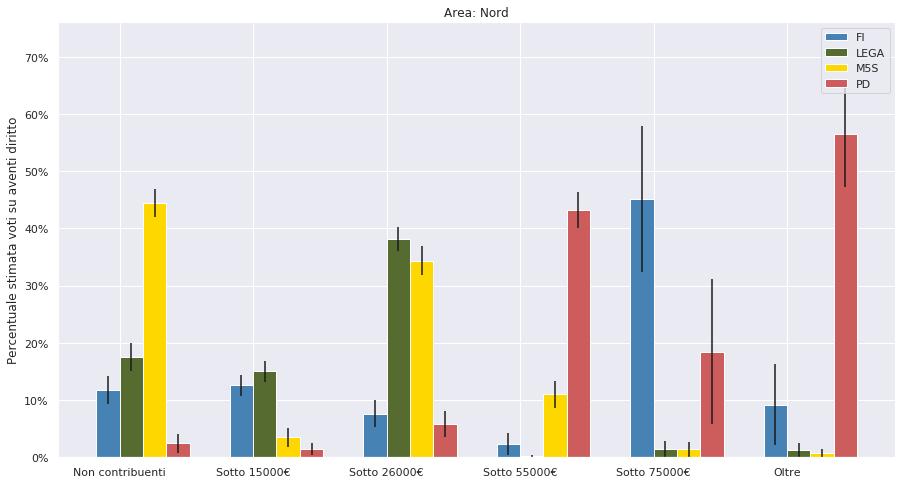

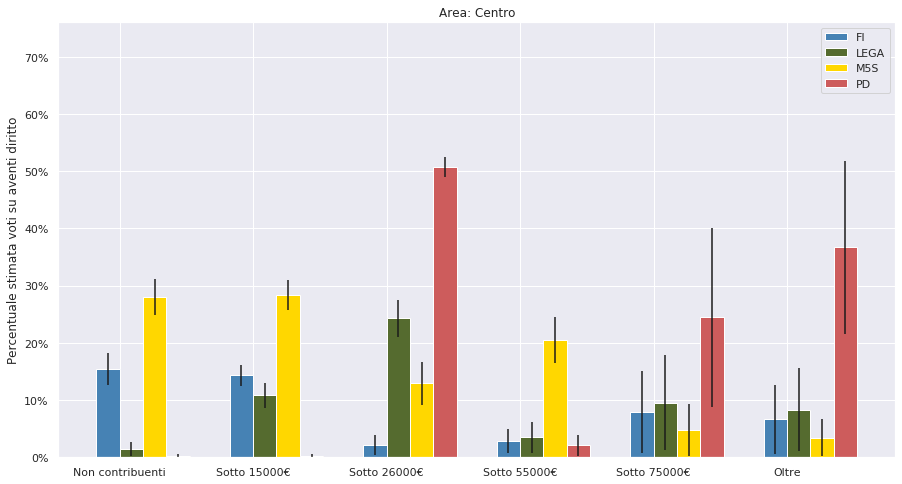

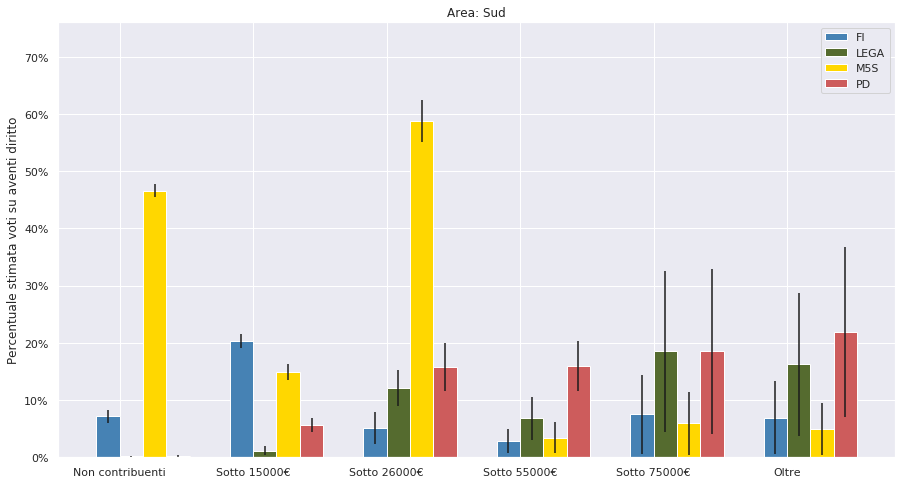

In [112]:
for area in ['Nord', 'Centro', 'Sud']:
    plot(area2results, area, [
         ('FI', 'steelblue'),
         ('LEGA', 'darkolivegreen'),
         ('M5S', 'gold'),
         ('PD', 'indianred'),
    ], path=f'../plots/{area}-big-2018-politiche.pdf')

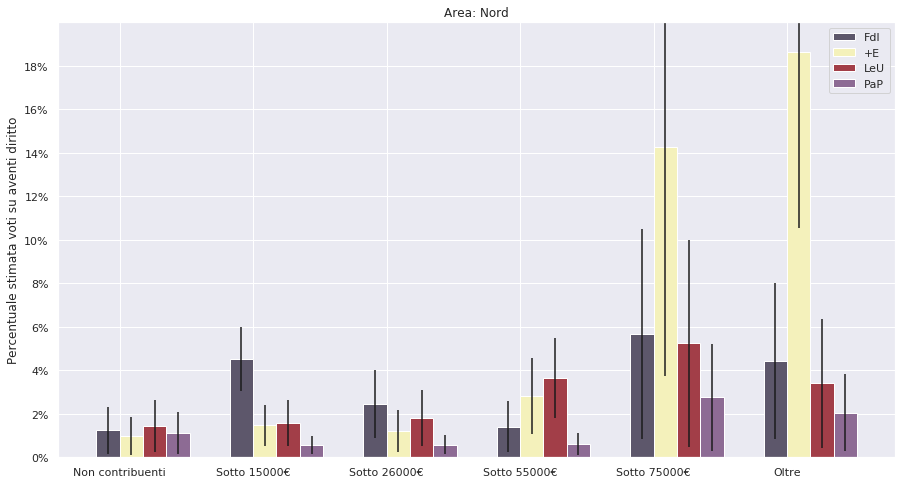

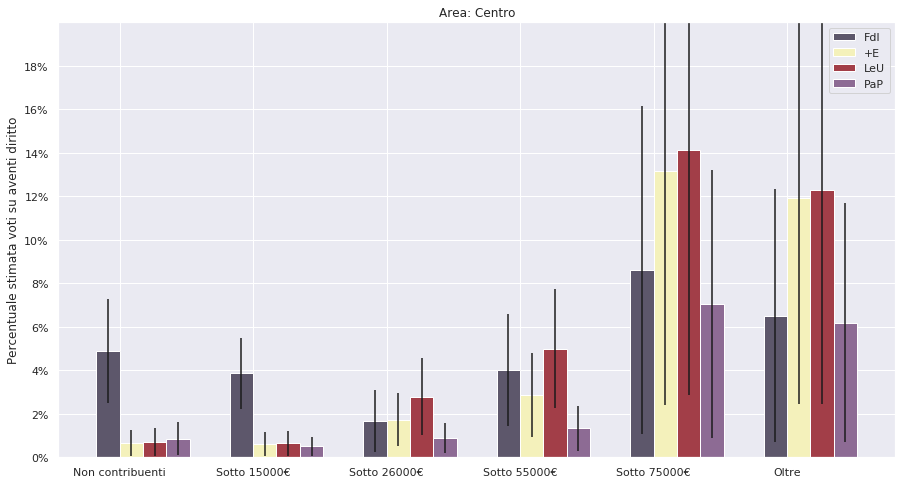

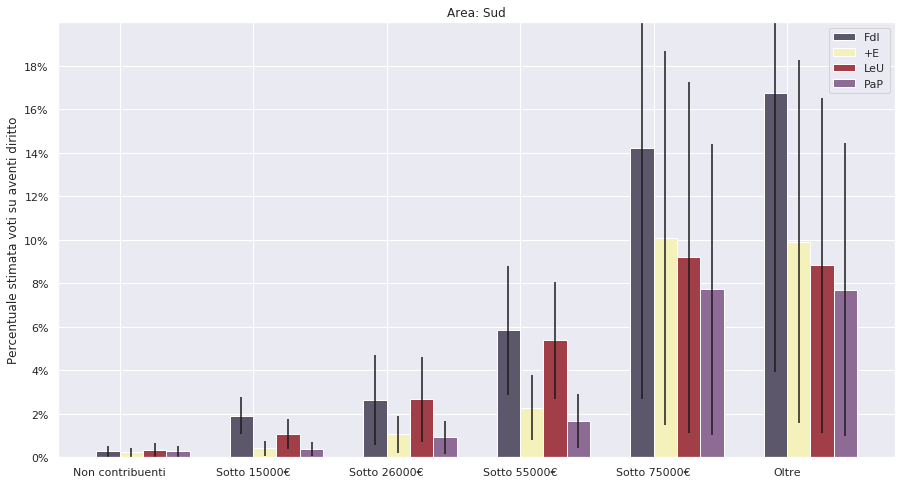

In [113]:
for area in ['Nord', 'Centro', 'Sud']:
    plot(area2results, area, [
         ('FdI', '#5d576b'),
         ('+E', '#f4f1bb'),
         ('LeU', '#a23e48'),
         ('PaP', '#8d6b94'),
    ], ylims=(0, 0.2, 0.02), path=f'../plots/{area}-small-2018-politiche.pdf')

# Elezioni Europee

### Raccolta dati

Iniziamo con il raccogliere i dati messi a disposizione dal ministero e formattarli in modo da ottenere una tabella identica a quella di prima.

In [88]:
voti_europee = pd.read_csv("../data/europee2019_scrutini_area_italia.csv", encoding='Latin-1', delimiter=";")[
    ['COMUNE', 'LISTA', 'VOTI_LISTA']
]

print(len(voti_europee[voti_europee.duplicated(subset=['COMUNE', 'LISTA'])]['COMUNE'].unique()),
      "comuni appaiono due volte. Li elimino")
voti_europee = voti_europee.drop_duplicates(subset=['COMUNE', 'LISTA'])

voti_europee = voti_europee.pivot_table(index='COMUNE', columns='LISTA', values='VOTI_LISTA',
                        margins=True).fillna(0).astype(int)

partiti2sigla_2019 = {
 '+EUROPA - ITALIA IN COMUNE - PDE ITALIA': '+E',
 'FORZA ITALIA': 'FI',
 "FRATELLI D'ITALIA": 'FdI',
 'LEGA SALVINI PREMIER': 'LEGA',
 'LA SINISTRA': 'S',
 'MOVIMENTO 5 STELLE': 'M5S',
 'PARTITO DEMOCRATICO': 'PD',
 'EUROPA VERDE': 'Verdi'
}

voti_europee = voti_europee[list(partiti2sigla_2019.keys())]
voti_europee = voti_europee.rename(partiti2sigla_2019, axis=1)
partiti_europee = list(partiti2sigla_2019.values())

elettori_europee = pd.read_csv("../data/europee2019_elettori_votanti_italia.csv",
                               encoding='Latin-1', delimiter=";")[
    ['COMUNE', 'ELETT_TOT']
].drop_duplicates(subset=['COMUNE'])

voti_europee = pd.merge(voti_europee, elettori_europee, left_on='COMUNE', right_on='COMUNE')[
    ['COMUNE', 'ELETT_TOT'] + partiti_europee
].rename({'ELETT_TOT': "ELETTORI"}, axis=1)

voti_europee.COMUNE = voti_europee.COMUNE.apply(lambda x: x.split("/")[0])

voti_europee.head()

6 comuni appaiono due volte. Li elimino


,COMUNE,ELETTORI,+E,FI,FdI,LEGA,S,M5S,PD,Verdi
0,ABANO TERME,16200,381,669,725,4395,84,1022,2212,271
1,ABBADIA CERRETO,227,3,20,9,88,1,11,43,3
2,ABBADIA LARIANA,2744,62,145,104,701,20,213,367,57
3,ABBADIA SAN SALVATORE,4977,83,123,114,1139,87,532,1177,86
4,ABBASANTA,2307,12,82,43,287,17,178,219,22


Ora, prendo la tabella dei dati Istat e eseguo la stessa pipeline di prima:

In [89]:
voti_redditi_2019 = pd.merge(voti_europee, istat,
                        left_on='COMUNE',
                        right_on='Denominazione Comune',
                        validate='1:m')

voti_redditi_2019 = voti_redditi_2019[ ['Regione', 'COMUNE', 'ELETTORI'] + partiti_europee + reddito_colonne ]

voti_redditi_2019[reddito_colonne] = voti_redditi_2019[reddito_colonne].fillna(0).astype(int)

for classe in classi:
    if classe == 'Non contribuenti':
        continue
    voti_redditi_2019[classe] = sum([voti_redditi_2019[c] for c in definizione_classi[classe]])
    for c in definizione_classi[classe]:
        del voti_redditi_2019[c]

voti_redditi_2019['Non contribuenti'] = (voti_redditi_2019.ELETTORI -
                                         sum(voti_redditi_2019[c] for c in classi if c != 'Non contribuenti')
                                        ).clip(lower=0)

# C'è un singolo comune con 200 elettori anzichè 243 (somma dei voti).
# voti_redditi_2019.loc[voti_redditi.COMUNE == 'SAUZE DI CESANA', ['ELETTORI']] = 243

voti_redditi_2019['Non voto'] = voti_redditi_2019.ELETTORI - sum(
                        voti_redditi_2019[p] for p in partiti_europee)

partiti_europee = ['Non voto'] + partiti_europee
assert not any(voti_redditi_2019['Non voto'] < 0)

voti_redditi_2019['area'] = voti_redditi_2019['Regione'].apply(regione2area.__getitem__)

voti_redditi_2019.head()

,Regione,COMUNE,ELETTORI,+E,FI,FdI,LEGA,S,M5S,PD,Verdi,Sotto 15000€,Sotto 26000€,Sotto 55000€,Sotto 75000€,Oltre,Non contribuenti,Non voto,area
0,Veneto,ABANO TERME,16200,381,669,725,4395,84,1022,2212,271,5324,4904,3213,420,562,1777,6441,Nord
1,Lombardia,ABBADIA CERRETO,227,3,20,9,88,1,11,43,3,82,64,43,0,0,38,49,Nord
2,Lombardia,ABBADIA LARIANA,2744,62,145,104,701,20,213,367,57,798,838,619,77,72,340,1075,Nord
3,Toscana,ABBADIA SAN SALVATORE,4977,83,123,114,1139,87,532,1177,86,2255,1775,734,69,37,107,1636,Centro
4,Sardegna,ABBASANTA,2307,12,82,43,287,17,178,219,22,798,463,404,17,11,614,1447,Sud


Eseguiamo MCMC su questi dati, con la stessa procedura di prima:

In [ ]:
area2results_2019 = {area: run_mcmc(voti_redditi_2019, area, partiti=partiti_europee)
                     for area in ['Nord', 'Centro', 'Sud']}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p5, p4, p3, p2, p1, p0, sigma]
Sampling 3 chains:   0%|          | 39/16500 [00:02<1:26:27,  3.17draws/s]

In [102]:
with open("area2results_2019.pickle", "wb") as output_file:
    pickle.dump(area2results_2019, output_file)

## Risultati (Europee 2019)

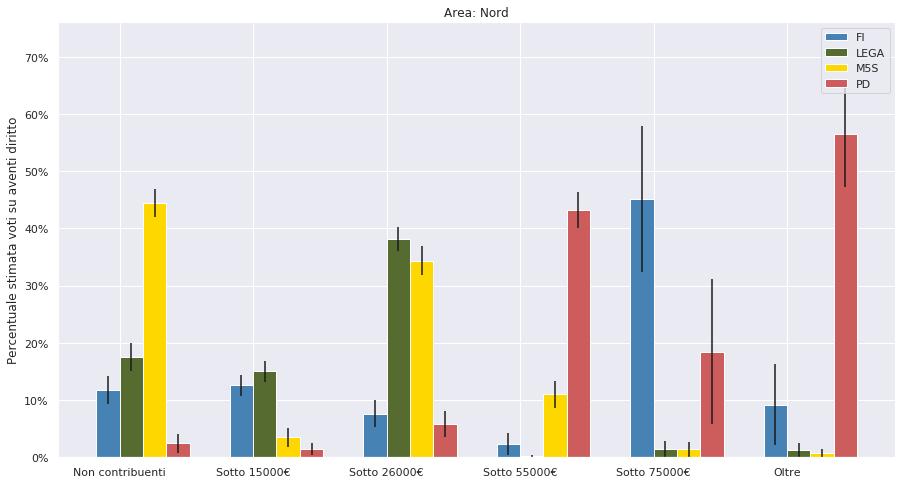

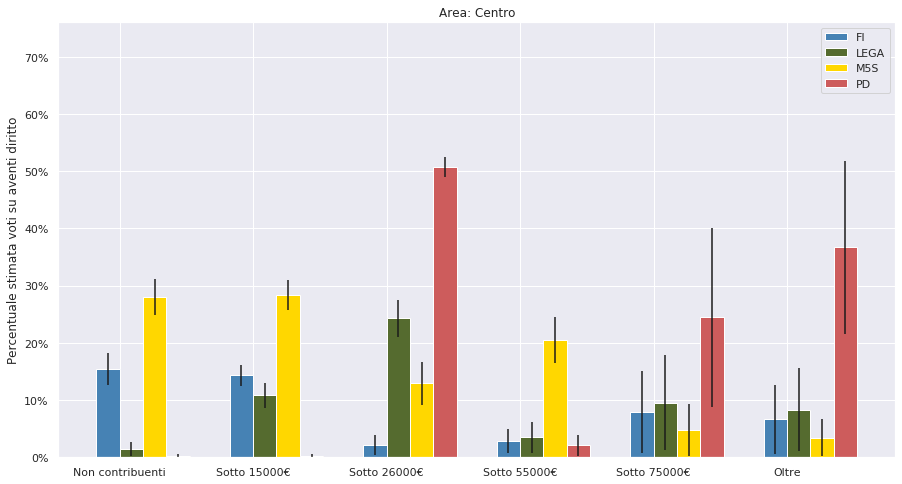

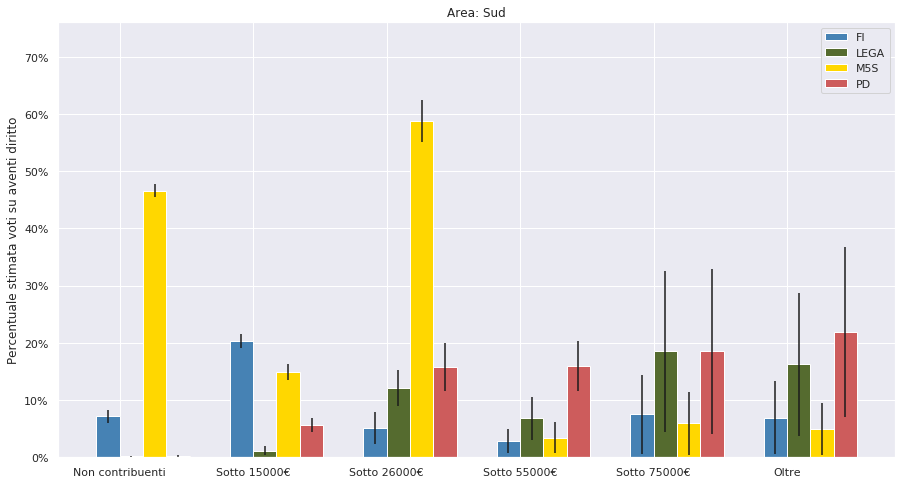

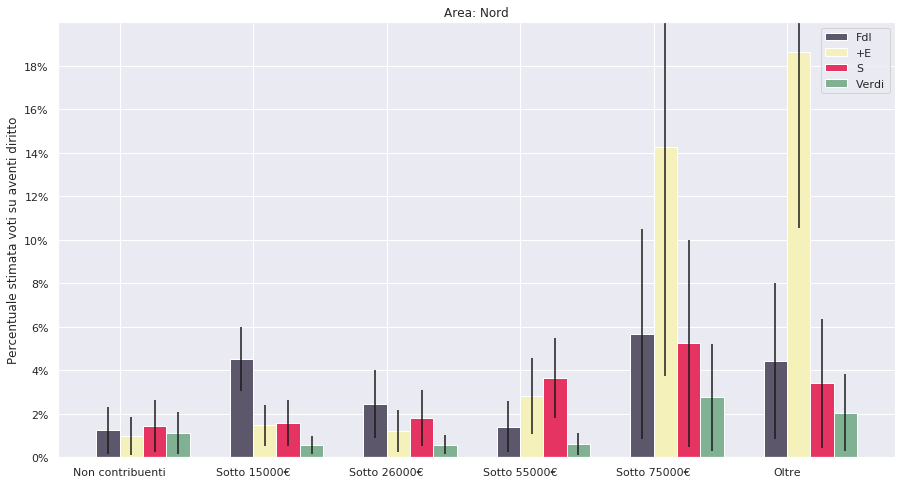

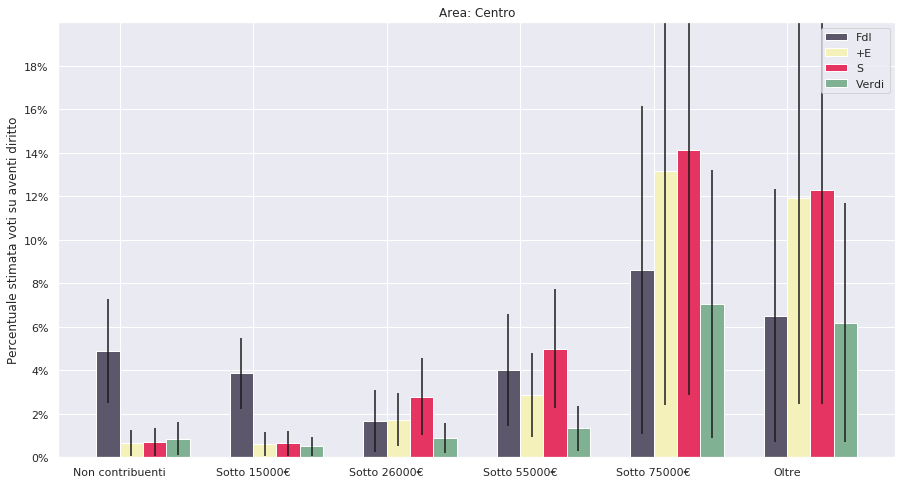

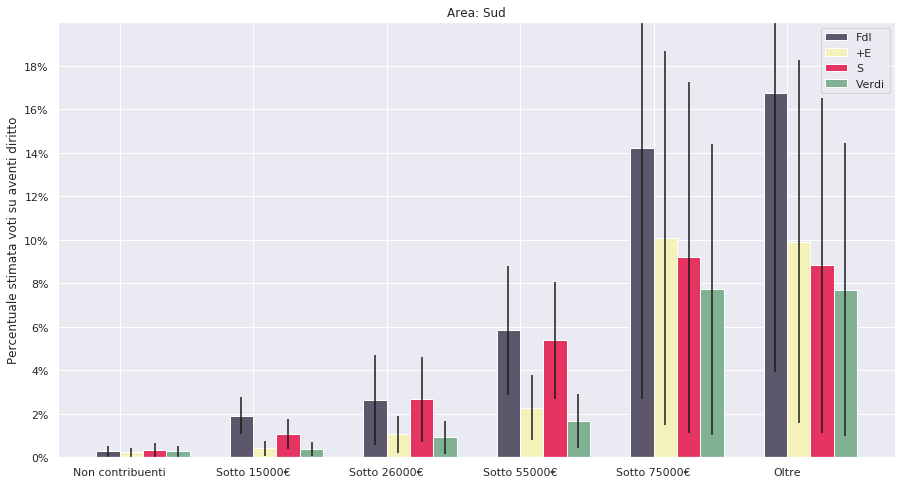

In [114]:
for area in ['Nord', 'Centro', 'Sud']:
    plot(area2results, area, [
         ('FI', 'steelblue'),
         ('LEGA', 'darkolivegreen'),
         ('M5S', 'gold'),
         ('PD', 'indianred'),
    ], partiti=partiti_europee, path=f'../plots/{area}-big-2019-europee.pdf')
    
for area in ['Nord', 'Centro', 'Sud']:
    plot(area2results, area, [
         ('FdI', '#5d576b'),
         ('+E', '#f4f1bb'),
         ('S', '#e63462'),
         ('Verdi', '#80b192'),
    ], partiti=partiti_europee, ylims=(0, 0.2, 0.02), path=f'../plots/{area}-small-2019-europee.pdf')